<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>"Глубокое обучение". Продвинутый поток</b></h3>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## 0. Data preparation

In [2]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=100,
    shuffle=False, 
    num_workers=2
)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 1. Custom Convolutional model

Попробуем написать свою собственную маленькую конволюционную модель

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [0]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [0]:
import torchsummary

In [6]:
torchsummary.summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
            Conv2d-3           [-1, 10, 28, 28]           5,770
              ReLU-4           [-1, 10, 28, 28]               0
           Flatten-5                 [-1, 7840]               0
            Linear-6                   [-1, 10]          78,410
Total params: 85,972
Trainable params: 85,972
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.06
Params size (MB): 0.33
Estimated Total Size (MB): 1.40
----------------------------------------------------------------


## 2. Write train and test function

In [0]:
def train(model, optim, criterion, dataloader, epoch, device):
    total = 0
    correct = 0
    train_loss = 0
    
    model.train()
    for data, label in dataloader:
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        pred = output.argmax(1)
        total += output.shape[0]
        correct += pred.eq(label).sum().item()
    return train_loss / total, 100. * correct / total

In [0]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
    total = 0
    correct = 0
    test_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            
            loss = criterion(output, label)
            
            test_loss += loss
            pred = output.argmax(1)
            correct += torch.eq(pred, label).sum().item()
            total += data.shape[0]
    
    acc = 100.*correct/total
    if acc > best_acc:
        # print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_{}.pth'.format(model_name))
    
    return test_loss / total, acc
    

## 3. Train Model

In [0]:
from IPython.display import clear_output
import numpy as np

In [0]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

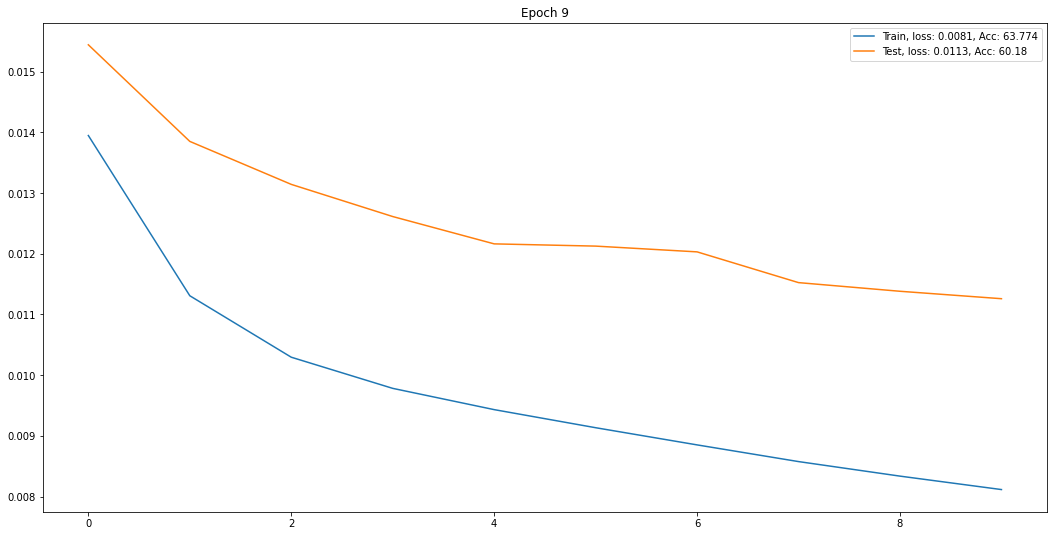

In [11]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc)
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [12]:
best_acc

60.18

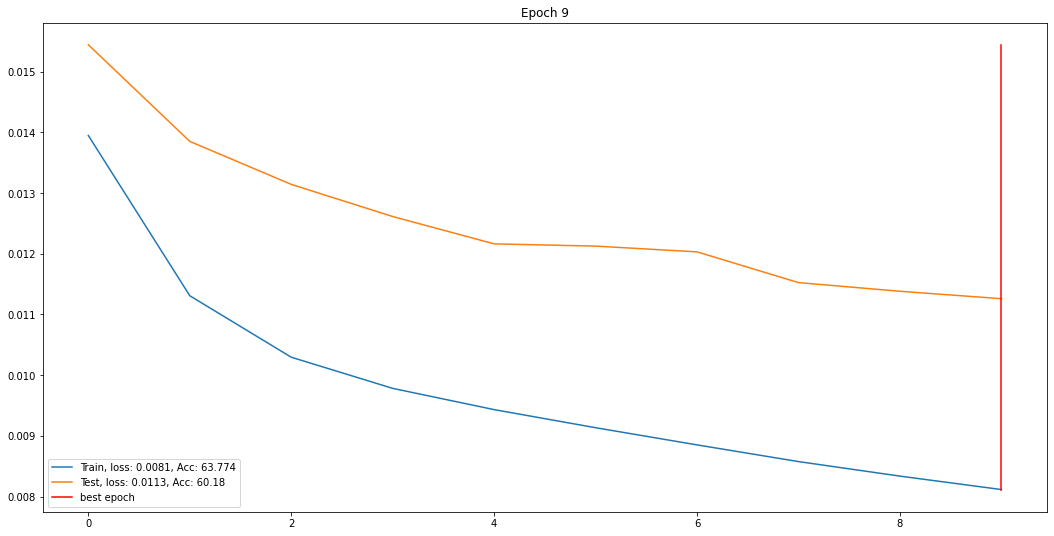

In [13]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
plt.title(f'Epoch {i}')
plt.legend(loc='best')

### BatchNorm

https://arxiv.org/abs/1502.03167

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png)

In [0]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('bn2', nn.BatchNorm2d(10))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [16]:
torchsummary.summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
       BatchNorm2d-2           [-1, 64, 30, 30]             128
              ReLU-3           [-1, 64, 30, 30]               0
            Conv2d-4           [-1, 10, 28, 28]           5,770
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
           Flatten-7                 [-1, 7840]               0
            Linear-8                   [-1, 10]          78,410
Total params: 86,120
Trainable params: 86,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.56
Params size (MB): 0.33
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


In [0]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

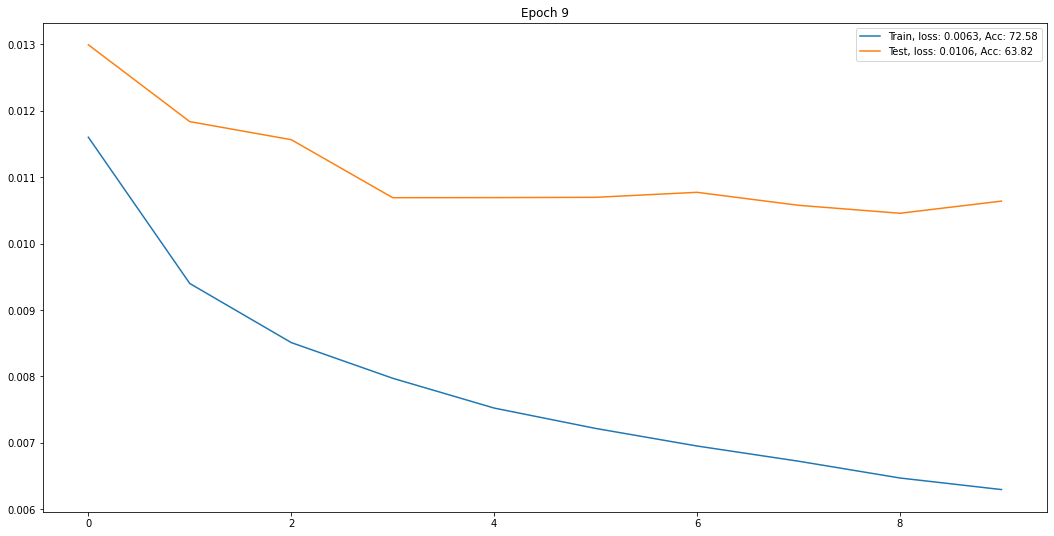

In [18]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'with_bn')
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [19]:
best_acc

63.86

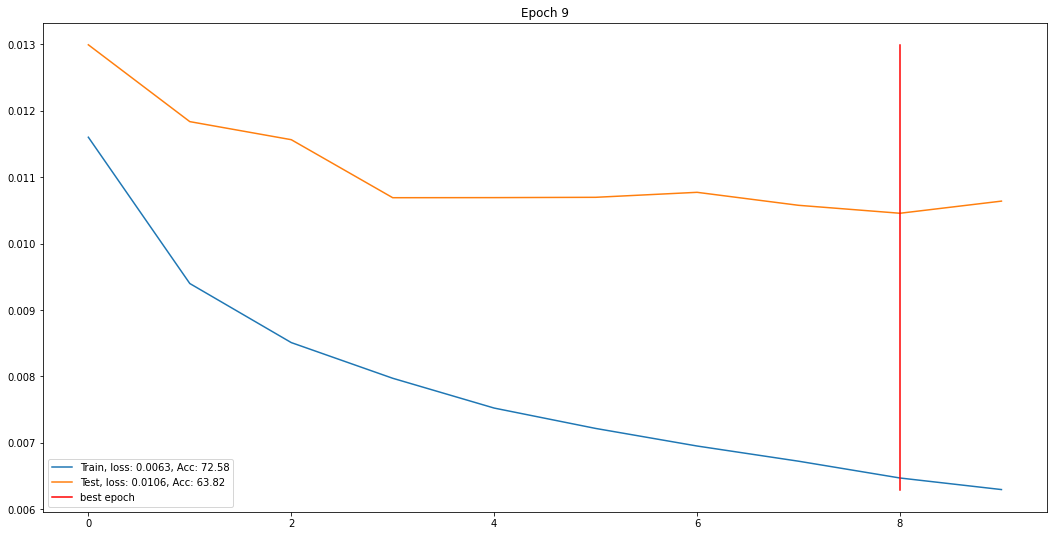

In [20]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
plt.title(f'Epoch {i}')
plt.legend(loc='best')

## 4. Add some augmentations

https://pytorch.org/docs/stable/torchvision/transforms.html

Добавим пару аугментаций (`Crop` & `Flip`) и посмотрим, как изменится обучение

In [21]:
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('bn2', nn.BatchNorm2d(10))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [0]:
def train(model, optim, criterion, dataloader, epoch, device, add_noise=True):
    total = 0
    correct = 0
    train_loss = 0
    
    model.train()
    for data, label in dataloader:
        if add_noise:
            data = data + torch.empty(*data.size()).normal_(0, 0.0001)
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        pred = output.argmax(1)
        total += output.shape[0]
        correct += pred.eq(label).sum().item()
    return train_loss / total, 100. * correct / total

In [0]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

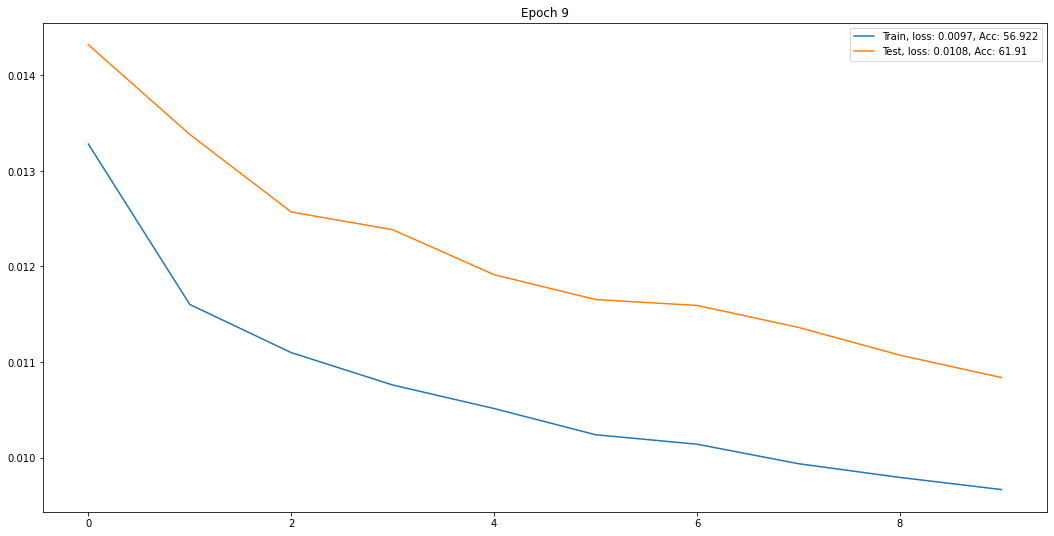

In [25]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'bn_and_aug')
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [26]:
best_acc

61.91

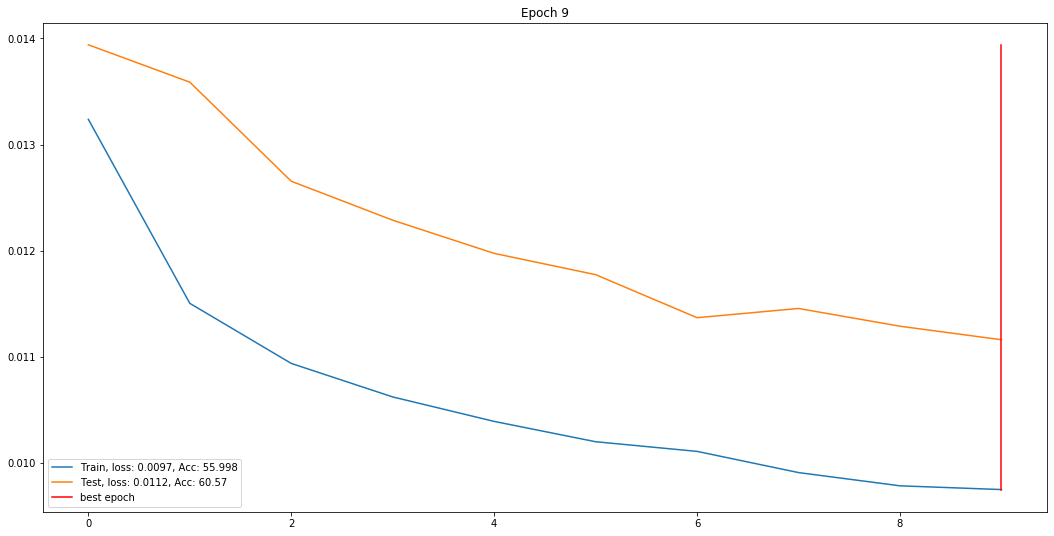

In [0]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
plt.title(f'Epoch {i}')
plt.legend(loc='best')

## 5. Model CNN Zoo

### VGG

https://arxiv.org/abs/1409.1556

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [0]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [0]:
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

### Inception
https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202

### Inception block

![](https://github.com/andreyzharkov/cs231n-seminars/blob/master/week3-layers-and_architectures/images/inception_naive.png?raw=true)

![](https://github.com/andreyzharkov/cs231n-seminars/blob/master/week3-layers-and_architectures/images/inception_module.png?raw=true)

In [0]:
# source: torchvision
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)
    

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj,
                 conv_block=None):
        super(Inception, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1),
            conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            conv_block(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1)
        )

    def _forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)

### ResNet

<a href='https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624'>blogpost 1</a>

<a href='https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035'> blogpost 2</a>

The key idea is to modify our layer transformation function in such a way that allows better and more stable training. Instead of learning transformation function $F(x)$ you learn another function $G(x)=F(x)-x$, but your layer is computed as $F(x)=G(x)+x$ which is the equivalent.

There may be different orderings of the operations in the residual part. The one proposed in original paper was proved to converge worse with the increase of depth, to the extent that very deep ResNets were actually less powerfull than Resnet50. Among the other variants, pre-activation order (bn-relu-conv) converges faster.

![](https://github.com/andreyzharkov/cs231n-seminars/raw/190a317ddccfc6b02235325d692a74fd742f6e1a/week3-layers-and_architectures/images/resnet_ordering.png)

In [0]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

### ResNeXt

One more idea is to apply group convolution (more parameter-efficient)

![](https://github.com/andreyzharkov/cs231n-seminars/raw/190a317ddccfc6b02235325d692a74fd742f6e1a/week3-layers-and_architectures/images/resnext_block.png)

![](https://miro.medium.com/max/1335/1*cIm3uy7eNvEchxRbBeBScQ.png)

<a href='https://towardsdatascience.com/review-resnext-1st-runner-up-of-ilsvrc-2016-image-classification-15d7f17b42ac'>
ResNeXt overview </a>

In [0]:
class Block(nn.Module):
    '''Grouped convolution block.'''
    expansion = 2

    def __init__(self, in_planes, cardinality=32, bottleneck_width=4, stride=1):
        super(Block, self).__init__()
        group_width = cardinality * bottleneck_width
        self.conv1 = nn.Conv2d(in_planes, group_width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)
        self.conv2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width)
        self.conv3 = nn.Conv2d(group_width, self.expansion*group_width, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*group_width)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*group_width:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*group_width, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*group_width)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

## 6. Pretrained NN

https://pytorch.org/docs/stable/torchvision/models.html

In [0]:
from torchvision.models import resnet18

In [33]:
model = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [34]:
torchsummary.summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [35]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
model.fc = nn.Linear(in_features=512, out_features=10)

In [38]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

5130

In [0]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

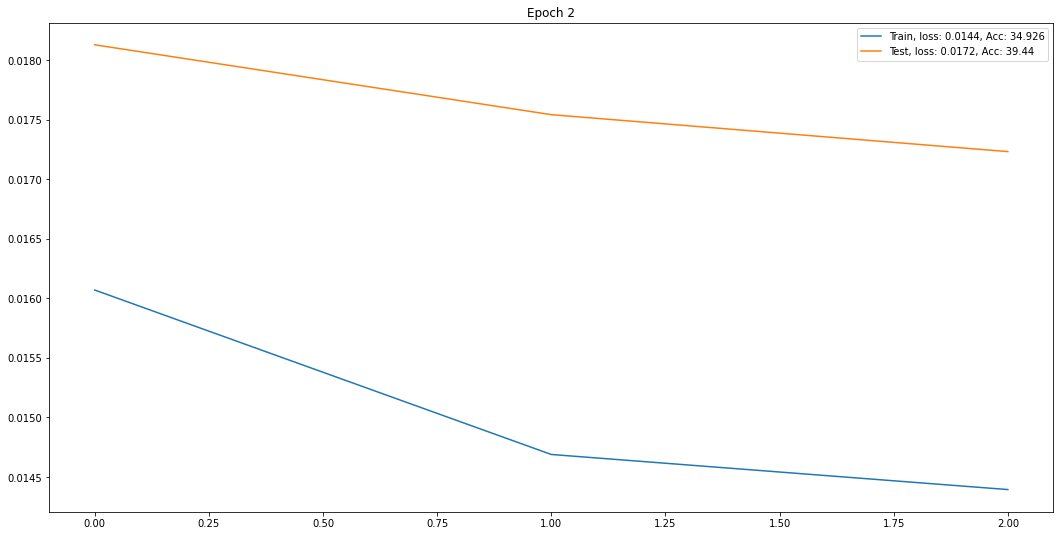

In [40]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(3):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'resnet')
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [0]:
for param in model.parameters():
    param.requires_grad = True

In [42]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

11181642

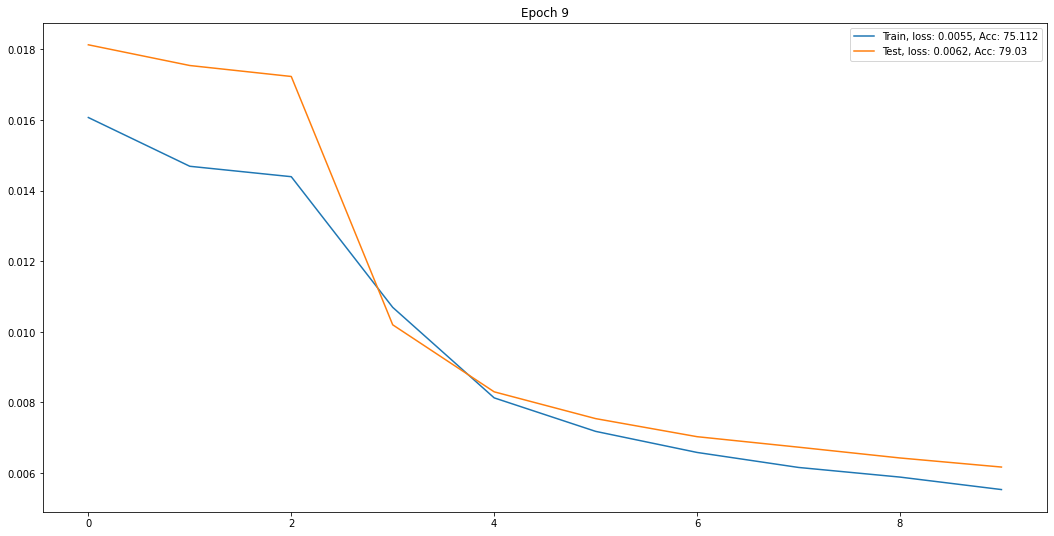

In [43]:
for i in range(3, 10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'resnet')
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [44]:
best_acc

79.03

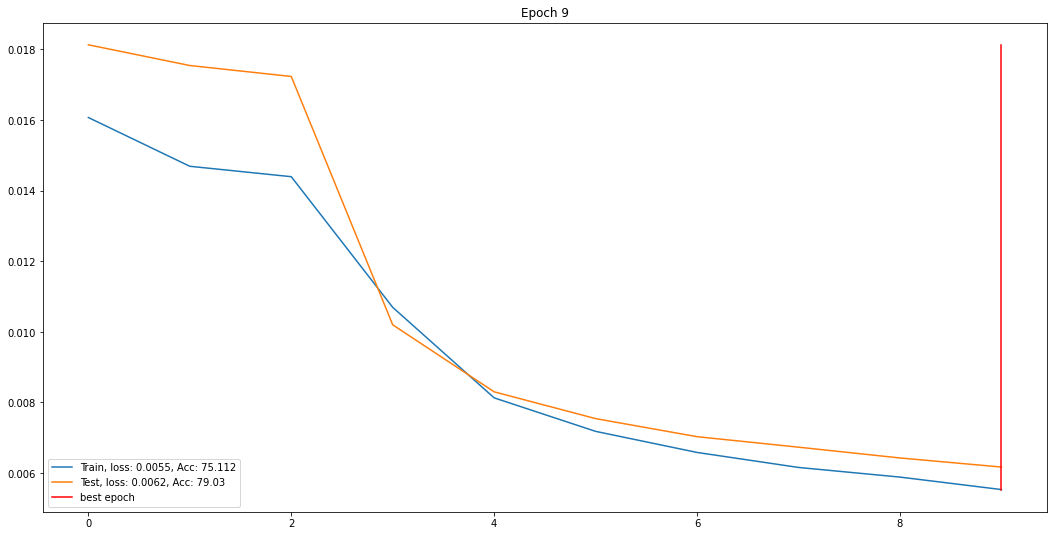

In [45]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
plt.title(f'Epoch {i}')
plt.legend(loc='best')